In [15]:
import numpy as np 
import pandas as pd
import os

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [16]:
# load datasets
# train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
# test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

train = pd.read_csv('Data/disaster_tweets_kaggle/train.csv')
test = pd.read_csv('Data/disaster_tweets_kaggle/test.csv')

In [17]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<Axes: xlabel='target', ylabel='count'>

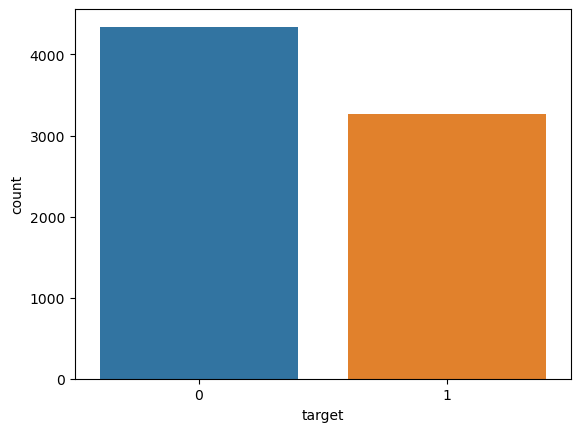

In [21]:
# let's check if the training data is balanced
sns.countplot(x = 'target', data = train)

<Axes: >

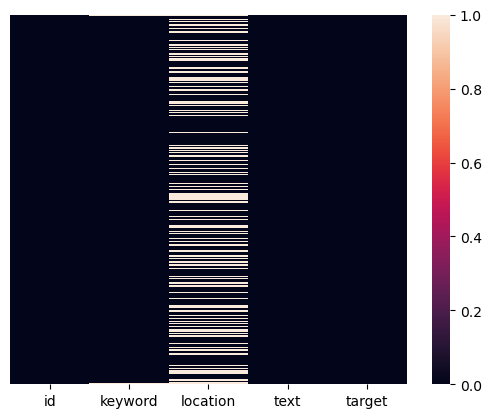

In [22]:
# visualizing null values
sns.heatmap(train.isnull(),yticklabels = False)

There are too many null values for location therefore the column will be dropped.

In [23]:
train.drop(['id', 'location'], axis = 1, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7552 non-null   object
 1   text     7613 non-null   object
 2   target   7613 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 178.6+ KB


In [24]:
train.groupby('keyword').count()

,text,target
keyword,,
ablaze,36,36
accident,35,35
aftershock,34,34
airplane%20accident,35,35
ambulance,38,38
...,...,...
wounded,37,37
wounds,33,33
wreck,37,37


Keywords can be helpful in classification, we will drop the rows with missing keywords as there are very few of them.

In [25]:
train.dropna(axis = 0, inplace = True)
train.reset_index(drop = True, inplace = True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7552 entries, 0 to 7551
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7552 non-null   object
 1   text     7552 non-null   object
 2   target   7552 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 177.1+ KB


In [26]:
train.tail(10)

,keyword,text,target
7542,wrecked,Had an awesome time gettin wrecked at bowling ...,0
7543,wrecked,Cramer: 3 words that wrecked DIS stock - http:...,0
7544,wrecked,On the bright side I wrecked http://t.co/uEa0t...,0
7545,wrecked,He just wrecked all of you http://t.co/y46isyZkC8,0
7546,wrecked,@widda16 ... He's gone. You can relax. I thoug...,0
7547,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both,0
7548,wrecked,Three days off from work and they've pretty mu...,0
7549,wrecked,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7550,wrecked,@engineshed Great atmosphere at the British Li...,0
7551,wrecked,Cramer: Iger's 3 words that wrecked Disney's s...,0


In [27]:
# let's check the test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## Training Data Analysis

To decide what strategy to use for data processing and what type of a model to use, the training data must be thoroughly analyzed. Firstly, we will check if all keywords are related to disaster and formulate a method to identify which ones are more relevant with the help of the associated target value.

In [28]:
# create a series of unique keywords
pd.Series(train.groupby('keyword').count().index, name = 'keyword')

0                   ablaze
1                 accident
2               aftershock
3      airplane%20accident
4                ambulance
              ...         
216                wounded
217                 wounds
218                  wreck
219               wreckage
220                wrecked
Name: keyword, Length: 221, dtype: object

As most keywords seem to be asscoiated with disasters, we need to perform feature engineering to extract useful information from the distribution of these keywords with respect to the target class

### Text preprocessing using NLTK
Each keyword will be converted into its root form so that keyword like 'blood' and 'bloody' will be considered as the same keywords. Same goes for all keywords that are closely related in the same manner.

In [29]:
import nltk

In [30]:
from nltk.stem.porter import PorterStemmer

In [31]:
# create a stemmer
stemmer = PorterStemmer()

In [32]:
def get_stemmed_keyword(keyword):
    return stemmer.stem(keyword)

def get_tokens(text):
    return word_tokenize(text)

In [33]:
# create a column with stemmed keyword
train['stemmed_keyword'] = train['keyword'].apply(get_stemmed_keyword)

In [34]:
def get_disaster_association(keyword):
    
    # get the number of times the keyword is associated with a true disaster tweet
    target_0_count = (train[train['stemmed_keyword'] == keyword]['target'] == 0).sum()
    
    # get the number of times the keyword is not associated with a true disaster tweet
    target_1_count = (train[train['stemmed_keyword'] == keyword]['target'] == 1).sum()
    
    # association value = true association count / total
    return target_1_count/(target_0_count + target_1_count)

In [35]:
# create columns with the keyword's association to actual disaster tweeets
train['association_coeff'] = train['stemmed_keyword'].apply(get_disaster_association)

In [36]:
train.head(20)

,keyword,text,target,stemmed_keyword,association_coeff
0,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,ablaz,0.361111
1,ablaze,We always try to bring the heavy. #metal #RT h...,0,ablaz,0.361111
2,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,ablaz,0.361111
3,ablaze,Crying out for more! Set me ablaze,0,ablaz,0.361111
4,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,ablaz,0.361111
5,ablaze,@PhDSquares #mufc they've built so much hype a...,0,ablaz,0.361111
6,ablaze,INEC Office in Abia Set Ablaze - http://t.co/3...,1,ablaz,0.361111
7,ablaze,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,ablaz,0.361111
8,ablaze,Ablaze for you Lord :D,0,ablaz,0.361111
9,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,ablaz,0.361111


In [37]:
# save association oefficients as a dictionary for transformation
association_dict = train.groupby('stemmed_keyword')['association_coeff'].mean().sort_values(ascending = False).to_dict()

### Text processing
Next, each text will be processed such that only important information will be retained. Foe example, hyperlinks and hashtag symbols will be removed

In [49]:
print(train['text'][7])
print(train['text'][8])
print(train['text'][9])
print(train['text'][10])
print(train['text'][11])

Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
Ablaze for you Lord :D
Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
on the outside you're ablaze and alive
but you're dead inside
Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??


In [54]:
c1 = train['text'][5].split('http')[0].strip()
c2 = ''.join(c1.split('#'))
' '.join([word for word in c2.split() if '@' not in word])

"mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season."

In [ ]:
def get_clean_text(raw_text):
    
    # remove hyperlink
    text_c1 = raw_text.split('http')[0].strip()
    
    # remove hashtags
    text_c2 = ''.join(text_c1.split('#'))
    
    # remove username
    text_c3 = ' '.join([word for word in wordtext_c2.split() if '@' not in word])
    
    # convert text to lowercase
    text_c4 = text_c3.lower()
    
    return text_c4

### Identifying Location mentions in Tweet
Mentions of a certain area, city or country in the tweet can be useful in identifying whether the tweet is related to disaster or as tweets with a location mentoned are more likely to be linked to disaster. To implement this we will use the <b>geography</b> package.

In [ ]:
!pip uninstall geography

In [ ]:
# install geotext 
!pip install geotext

In [ ]:
from geotext import GeoText

def contains_location(text):
    locations = GeoText(text)
    

## Sentiment Analysis (NLTK)
Although keywords can be an important factor in this type of classification, the overall sentiment of the tweet can also provide crucial information regarding the nature of the tweet. Although a custom model can be trained to predict sentiment, for this project I am using the <b> NLTK VADER </b> library which relies on a rule based sentiment-analyzer.

In [177]:
nltk.download([
     "names",
     "stopwords",     "state_union",
     "twitter_samples",
    "movie_reviews",
    "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
 ])

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\shisk\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shisk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\shisk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\state_union.zip.
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\shisk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\shisk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shisk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading packag

True

In [178]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [211]:
# returns a dictionary of values
def get_sentiment_val(text):
    res_dict = sia.polarity_scores(text)
    return pd.Series([res_dict['neg'], res_dict['neu'], res_dict['pos']])

In [212]:
train[['neg', 'neu', 'pos']] = train['text'].apply(get_sentiment_val)

In [213]:
train.head()

,keyword,text,target,stemmed_keyword,association_coeff,neg,neu,pos
0,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,ablaz,0.361111,0.000,1.000,0.0
1,ablaze,We always try to bring the heavy. #metal #RT h...,0,ablaz,0.361111,0.000,1.000,0.0
2,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,ablaz,0.361111,0.000,1.000,0.0
3,ablaze,Crying out for more! Set me ablaze,0,ablaz,0.361111,0.361,0.639,0.0
4,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,ablaz,0.361111,0.000,1.000,0.0


In [220]:
# save processed training data to avoid preprocessing time
train.drop(['keyword', 'text',
            'stemmed_keyword'], axis = 1).to_csv('Data/disaster_tweets_kaggle/cleaned_train.csv', index = False)

In [6]:
# load data
df = pd.read_csv('Data/disaster_tweets_kaggle/cleaned_train.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7552 entries, 0 to 7551
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   target             7552 non-null   int64  
 1   association_coeff  7552 non-null   float64
 2   neg                7552 non-null   float64
 3   neu                7552 non-null   float64
 4   pos                7552 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 295.1 KB


Analyze distribution with respect to different attributes

### Distribution of keyword association coefficient

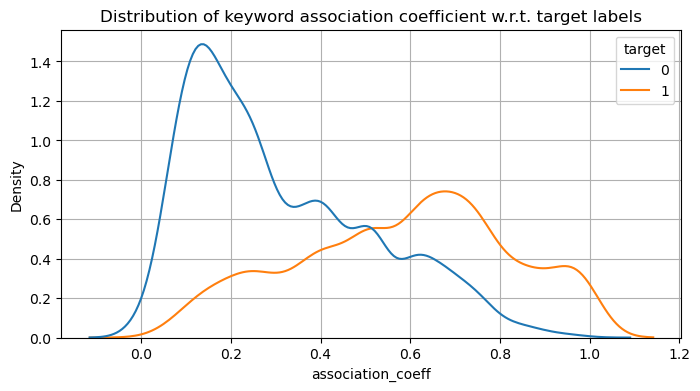

In [9]:
plt.figure(figsize = (8,4))
sns.kdeplot(df, x = 'association_coeff', hue = 'target')
plt.title('Distribution of keyword association coefficient w.r.t. target labels')
plt.grid()

The above KDE plot shows that distribution of keyword association coefficients for non disaster tweets is more towards the left as opposed to that of disaster related tweets.

### Distribution of different sentiment tags

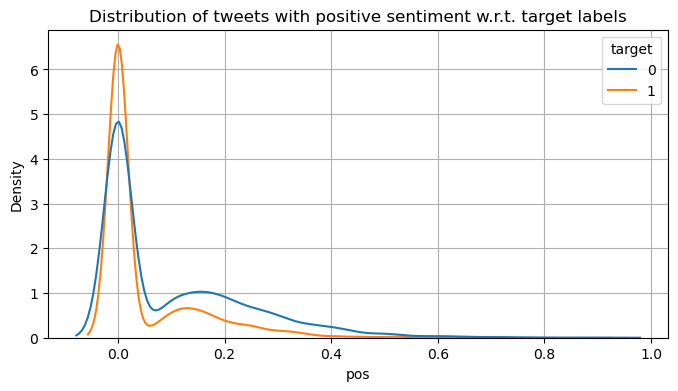

In [10]:
plt.figure(figsize = (8,4))
sns.kdeplot(df, x = 'pos', hue = 'target')
plt.title('Distribution of tweets with positive sentiment w.r.t. target labels')
plt.grid()

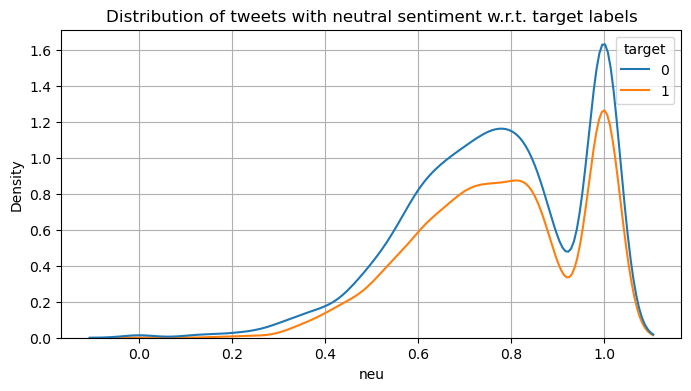

In [11]:
plt.figure(figsize = (8,4))
sns.kdeplot(df, x = 'neu', hue = 'target')
plt.title('Distribution of tweets with neutral sentiment w.r.t. target labels')
plt.grid()

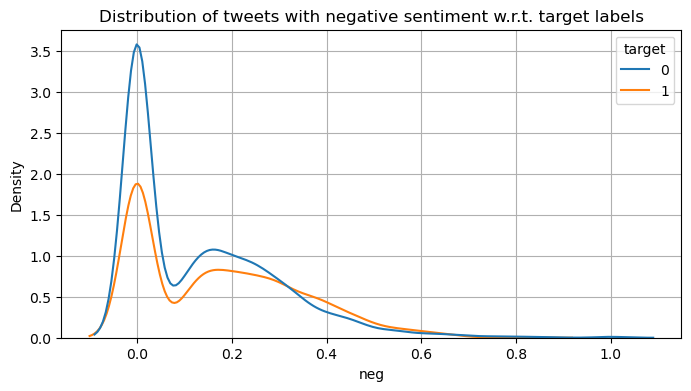

In [12]:
plt.figure(figsize = (8,4))
sns.kdeplot(df, x = 'neg', hue = 'target')
plt.title('Distribution of tweets with negative sentiment w.r.t. target labels')
plt.grid()

As we can clearly see that both targets have similar distribution for all sentiment tags given by NLTK's VADER sentiment analysis package, using these attributes for model training will not be too useful.

### Train Test Split

In [215]:
from sklearn.model_selection import train_test_split

In [226]:
# drop all columns except 'association coefficient' and those related to sentiment analysis
X = train_processed.drop('target', axis = 1)
y = train_processed['target']

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [228]:
X_train.head()

,association_coeff,neg,neu,pos
3913,0.605505,0.000,1.000,0.000
1674,0.351351,0.169,0.639,0.192
4447,0.617647,0.143,0.599,0.258
5293,0.216216,0.000,1.000,0.000
6897,0.151515,0.278,0.722,0.000


### Model Selection
As this is a classification problem, the simplest model that can be used is logistic regression. However, logistic regression only performs well for if classes are linearly separable. For data that is not linearly separable we can use KNN, SVC, Random Forests. All these models will be implemented and the results for each will be compared.